# CNN Architectures
In this notebook we will explore standard CNN architectures using PyTorch and torchvision.

You can find more information on how to finetune pretrained models [here](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from PIL import Image
# !pip install torchsummary
from torchsummary import summary

### CIFAR10 Dataset

In [2]:
# since we are going to use pretrained CNNs (on ImageNet), we need to normalize our data 
# according to the mean and std with which these networks were trained, i.e. with the statistics of the ImageNet dataset
data_aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=data_aug,
)
validation_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=data_aug,
)
print(f"Training size: {len(training_data)} \nValidation size: {len(validation_data)}")

100%|██████████| 170498071/170498071 [00:32<00:00, 5263073.87it/s] 


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Training size: 50000 
Validation size: 10000


In [3]:
# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# now we need to define a Dataloader, which allows us to automatically batch our inputs, do sampling and multiprocess data loading
batch_size = 64
num_workers = 2 # how many processes are used to load the data

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)

Using cpu device


### Training loop

In [4]:
def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."
      
    num_batches = len(dataloader)

    if is_train:
      model.train() # put model in train mode
    else:
      model.eval()

    total_loss = 0.0
    preds = []
    labels = []

    with torch.set_grad_enabled(is_train):
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          X, y = X.to(device), y.to(device)

          # Compute prediction error
          pred = model(X)
          loss = loss_fn(pred, y)

          if is_train:
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          # Save training metrics
          total_loss += loss.item() # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached

          probs = F.softmax(pred, dim=1)
          final_pred = torch.argmax(probs, dim=1)
          preds.extend(final_pred.cpu().numpy())
          labels.extend(y.cpu().numpy())

    return total_loss / num_batches, accuracy_score(labels, preds)

In [5]:
def train(model, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer):
  train_history = {'loss': [], 'accuracy': []}
  val_history = {'loss': [], 'accuracy': []}
  best_val_loss = np.inf
  print("Start training...")
  for t in range(num_epochs):
      print(f"\nEpoch {t+1}")
      train_loss, train_acc = epoch_iter(train_dataloader, model, loss_fn, optimizer)
      print(f"Train loss: {train_loss:.3f} \t Train acc: {train_acc:.3f}")
      val_loss, val_acc = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
      print(f"Val loss: {val_loss:.3f} \t Val acc: {val_acc:.3f}")

      # save model when val loss improves
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
        torch.save(save_dict, model_name + '_best_model.pth')

      # save latest model
      save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
      torch.save(save_dict, model_name + '_latest_model.pth')

      # save training history for plotting purposes
      train_history["loss"].append(train_loss)
      train_history["accuracy"].append(train_acc)

      val_history["loss"].append(val_loss)
      val_history["accuracy"].append(val_acc)
      
  print("Finished")
  return train_history, val_history

In [6]:
def plotTrainingHistory(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

### Custom CNN

In [13]:
# TODO
# define a custom CNN architecture
# copy the class used in the previous notebook (CNN Introduction)
# and adapt it to CIFAR-10 image shape - 32x32 with 3 colour channels
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionalNeuralNetwork, self).__init__()
        
        # TODO
        self.pool_size = 2
        self.nb_filters = 32
        self.kernel_size = 3

        self.layers = nn.Sequential(
            # TODO
            nn.Conv2d(3, self.nb_filters, self.kernel_size),    # Output 30x30x32   # Number of parameters: 896 = 3 * 3 * 3 * 32 + 32
            nn.ReLU(),
            nn.Conv2d(self.nb_filters, self.nb_filters, self.kernel_size),  # Output 28x28x32   # Number of parameters: 9248 = 3 * 3 * 32 * 32 + 32
            nn.ReLU(),
            nn.MaxPool2d(self.pool_size),   # Output 14x14x32   # Number of parameters: 0
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(6272, 128),  # Number of parameters: 802944 = 6272 * 128 + 128
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        logits = self.layers(x)
        return logits
    

custom_cnn = ConvolutionalNeuralNetwork()

custom_cnn.to(device)
print(custom_cnn)

ConvolutionalNeuralNetwork(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=6272, out_features=128, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=128, out_features=10, bias=True)
  )
)


Start training...

Epoch 1


100%|██████████| 781/781 [01:11<00:00, 10.93it/s]


Train loss: 2.250 	 Train acc: 0.162


100%|██████████| 157/157 [00:07<00:00, 21.41it/s]


Val loss: 2.160 	 Val acc: 0.249

Epoch 2


100%|██████████| 781/781 [01:14<00:00, 10.43it/s]


Train loss: 2.123 	 Train acc: 0.235


100%|██████████| 157/157 [00:06<00:00, 26.00it/s]


Val loss: 2.023 	 Val acc: 0.293

Epoch 3


100%|██████████| 781/781 [01:07<00:00, 11.59it/s]


Train loss: 2.033 	 Train acc: 0.271


100%|██████████| 157/157 [00:05<00:00, 26.96it/s]


Val loss: 1.934 	 Val acc: 0.323

Epoch 4


100%|██████████| 781/781 [01:05<00:00, 11.90it/s]


Train loss: 1.965 	 Train acc: 0.300


100%|██████████| 157/157 [00:05<00:00, 29.83it/s]


Val loss: 1.870 	 Val acc: 0.352

Epoch 5


100%|██████████| 781/781 [01:05<00:00, 11.97it/s]


Train loss: 1.915 	 Train acc: 0.316


100%|██████████| 157/157 [00:05<00:00, 27.88it/s]


Val loss: 1.823 	 Val acc: 0.366

Epoch 6


100%|██████████| 781/781 [01:02<00:00, 12.46it/s]


Train loss: 1.870 	 Train acc: 0.336


100%|██████████| 157/157 [00:05<00:00, 30.51it/s]


Val loss: 1.779 	 Val acc: 0.383

Epoch 7


100%|██████████| 781/781 [01:10<00:00, 11.05it/s]


Train loss: 1.836 	 Train acc: 0.347


100%|██████████| 157/157 [00:06<00:00, 25.28it/s]


Val loss: 1.746 	 Val acc: 0.391

Epoch 8


100%|██████████| 781/781 [01:07<00:00, 11.53it/s]


Train loss: 1.799 	 Train acc: 0.365


100%|██████████| 157/157 [00:06<00:00, 25.91it/s]


Val loss: 1.707 	 Val acc: 0.405

Epoch 9


100%|██████████| 781/781 [01:05<00:00, 11.94it/s]


Train loss: 1.771 	 Train acc: 0.371


100%|██████████| 157/157 [00:06<00:00, 24.24it/s]


Val loss: 1.673 	 Val acc: 0.411

Epoch 10


100%|██████████| 781/781 [00:55<00:00, 14.17it/s]


Train loss: 1.743 	 Train acc: 0.383


100%|██████████| 157/157 [00:04<00:00, 34.83it/s]


Val loss: 1.642 	 Val acc: 0.424
Finished


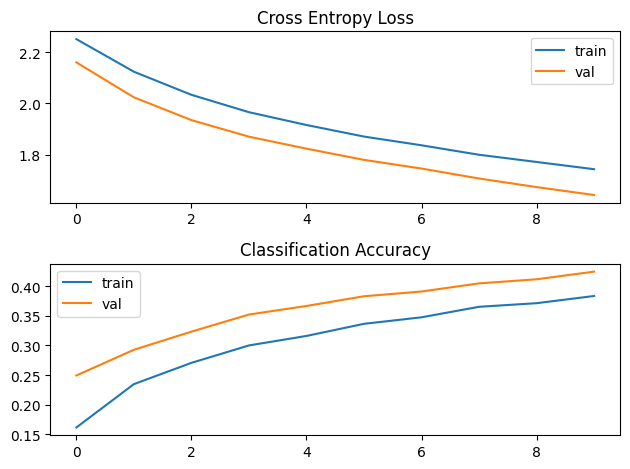

In [14]:
num_epochs = 10
model_name = 'custom CNN'

loss_fn = nn.CrossEntropyLoss() # already includes the Softmax activation
optimizer_custom = torch.optim.SGD(custom_cnn.parameters(), lr=1e-3)

custom_train_history, custom_val_history = train(custom_cnn, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer_custom)

plotTrainingHistory(custom_train_history, custom_val_history)

### 7x7 versus 3x3 Convolutions

Historically, the VGG was the first CNN architecture to introduce more layers (16-19 layers versus the 8 layers of AlexNet) and smaller convolutional kernel sizes (3x3).

This is mainly due to the fact that a stack of 3 3x3 convolutional layers (with stride 1) has the same effective receptive field as a single 7x7 layer. Why?

You can find out more about the effective receptive field of CNNs and explore some visualizations [here](https://blog.mlreview.com/a-guide-to-receptive-field-arithmetic-for-convolutional-neural-networks-e0f514068807).

Compare the number of parameters of a single convolutional layer with 7x7 kernel with a stack of 3 convolutional layers with 3x3 kernels.

In [16]:
# TODO
# consider convolutional layers with 1 input and output channels
# hint: use the summary method from the torchsummary package
m1 = nn.Sequential(nn.Conv2d(1, 1, kernel_size=(7, 7), padding=0)).to(device)
summary(m1, (1, 32, 32))

m2 = nn.Sequential(nn.Conv2d(1, 1, kernel_size=(7, 7), padding=0),
                   nn.Conv2d(1, 1, kernel_size=(7, 7), padding=0),
                   nn.Conv2d(1, 1, kernel_size=(7, 7), padding=0)
                   ).to(device)
                   

summary(m2, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 1, 26, 26]              50
Total params: 50
Trainable params: 50
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 1, 26, 26]              50
            Conv2d-2            [-1, 1, 20, 20]              50
            Conv2d-3            [-1, 1, 14, 14]              50
Total params: 150
Trainable params: 150
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (

What are the advantages of using a stack of 3 convolutional layers with 3x3 kernels instead of a single 7x7 layer?

### VGG model

Finetune a VGG-16 model.




In [17]:
# TODO
# load model from torchvision (with pretrained=True)
vgg = models.vgg16(pretrained=True)

# change the number of neurons in the last layer to the number of classes of the problem at hand (CIFAR10 dataset)
vgg.classifier[6] = nn.Linear(4096, 10)

vgg.to(device)
print(vgg)

/home/monkin/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/monkin/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/monkin/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [01:55<00:00, 4.77MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Inspect the model structure.

What does the AdaptiveAvgPool2d layer do?

What is the shape of the feature map before and after this layer?

In [ ]:
num_epochs = 10
model_name = 'vgg16'

loss_fn = nn.CrossEntropyLoss() # already includes the Softmax activation
optimizer_vgg = torch.optim.SGD(vgg.parameters(), lr=1e-3)

vgg_train_history, vgg_val_history = train(vgg, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer_vgg)

plotTrainingHistory(vgg_train_history, vgg_val_history)

### ResNet Model
Repeat the finetuning process with a ResNet-50 model.

In [ ]:
# TODO
# load model from torchvision (with pretrained=True)
resnet = models.resnet50(pretrained=True)

# change the number of neurons in the last layer to the number of classes of the problem at hand (CIFAR10 dataset)
resnet.fc = nn.Linear(2048, 10)

resnet.to(device)
print(resnet)

In [ ]:
num_epochs = 10
model_name = 'resnet50'

loss_fn = nn.CrossEntropyLoss() # already includes the Softmax activation
optimizer_resnet = torch.optim.SGD(resnet.parameters(), lr=1e-3)

resnet_train_history, resnet_val_history = train(resnet, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer_resnet)

plotTrainingHistory(resnet_train_history, resnet_val_history)

### Compare the VGG and ResNet models in terms of:


1.   number of parameters
2.   validation accuracy
3.   training time

What is the main difference introduced by the ResNet architecture?


In [18]:
# TODO

# use torchsummary to compare the number of parameters of the VGG-16 and the ResNet-50
# Count the number of paramters of the custom CNN
summary(custom_cnn, (3, 32, 32))

summary(vgg, (3, 32, 32))

summary(resnet, (3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
              ReLU-2           [-1, 32, 30, 30]               0
            Conv2d-3           [-1, 32, 28, 28]           9,248
              ReLU-4           [-1, 32, 28, 28]               0
         MaxPool2d-5           [-1, 32, 14, 14]               0
           Dropout-6           [-1, 32, 14, 14]               0
           Flatten-7                 [-1, 6272]               0
            Linear-8                  [-1, 128]         802,944
              ReLU-9                  [-1, 128]               0
          Dropout-10                  [-1, 128]               0
           Linear-11                   [-1, 10]           1,290
Total params: 814,378
Trainable params: 814,378
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

## Challenges (closer to the project)
Adapt the previous model, or use any of the well-known CNN architectures, to tackle one of (or both) these competitions, that consist of a binary medical image classification problem.

a) Identify metastatic cancer in small image patches (32x32) taken from larger digital pathology scans
https://www.kaggle.com/c/histopathologic-cancer-detection

b) Classify CT images into positive or negative COVID-19, depending if the image has or does not have clinical findings of COVID-19 https://covid-ct.grand-challenge.org/Data/